[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [1]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [ ]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [3]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

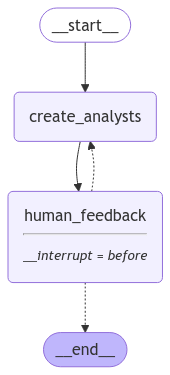

In [4]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

In [6]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [7]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6c730-ed11-660c-8002-c9533d30fd7b'}}

In [8]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technical Analyst
Description: Dr. Carter focuses on the technical benefits and challenges of adopting new frameworks. She is particularly interested in the performance, scalability, and integration capabilities of LangGraph.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Analyst
Description: Michael examines the business implications of adopting new technologies. He is concerned with cost-benefit analysis, return on investment, and the potential for LangGraph to provide a competitive edge.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: User Experience Research Lab
Role: UX Analyst
Description: Sophia is dedicated to understanding how new frameworks impact user experience. She evaluates the usability, learning curve, and overall satisfaction of developers and end-users when using LangGraph.
-----------------

In [9]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6c731-5ec7-6e04-8004-626a441d897c'}}

In [10]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [11]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [12]:
final_state.next

()

In [13]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Analyst
Description: Dr. Carter focuses on evaluating emerging technologies and their potential impact on various industries. She is particularly interested in how LangGraph can streamline processes and improve efficiency in tech-driven companies.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Green Ventures
Role: Startup Advisor
Description: Michael Thompson is an advisor for early-stage startups, helping them navigate the challenges of growth and innovation. He is keen on understanding how LangGraph can provide a competitive edge to startups by enhancing their operational capabilities.
--------------------------------------------------
Name: Sarah Lee
Affiliation: Global Enterprises Ltd.
Role: Business Strategist
Description: Sarah Lee specializes in developing strategic business plans for large enterprises. She is interested in how LangGraph can be integrated into existi

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [7]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [8]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [17]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [9]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [10]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

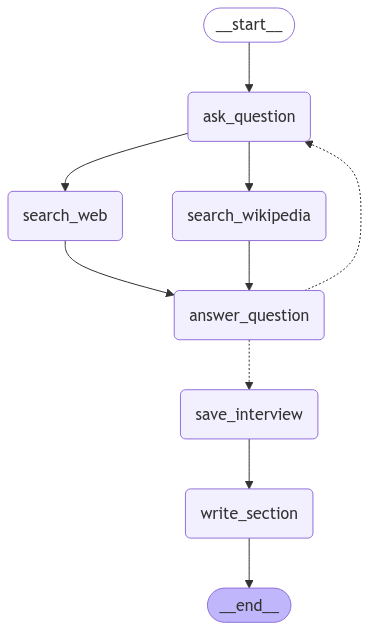

In [11]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [19]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Dr. Emily Carter', role='Technology Analyst', description='Dr. Carter focuses on evaluating emerging technologies and their potential impact on various industries. She is particularly interested in how LangGraph can streamline processes and improve efficiency in tech-driven companies.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [20]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph: Revolutionizing Agentic Applications in Tech-Driven Industries

### Summary

In the rapidly evolving landscape of emerging technologies, LangGraph stands out as a transformative tool for building stateful, multi-actor applications with large language models (LLMs). Dr. Carter's focus on evaluating such technologies reveals LangGraph's potential to streamline processes and enhance efficiency in tech-driven companies. This report delves into the core principles and benefits of LangGraph, highlighting its unique features and industry applications.

LangGraph, launched in January 2023, is a low-level orchestration framework designed to build agentic applications. It offers unparalleled controllability, allowing developers to define complex workflows involving cycles, which are essential for most agentic architectures [1]. This level of control is crucial for creating sophisticated, customized agentic systems that can adapt to specific business needs [2].

One of the most novel aspects of LangGraph is its ability to balance agent control with agency. This balance is achieved through its core principles: cycles, controllability, and persistence. These principles enable the creation of fully customizable agentic workflows, as opposed to rigid, boilerplate solutions [3]. This flexibility is particularly beneficial for developing advanced chatbots and other interactive applications that require nuanced and dynamic interactions [4].

LangGraph Studio further enhances the development process by providing an integrated development environment (IDE) tailored for agentic applications. This IDE streamlines the creation, testing, and deployment of agentic workflows, making it easier for developers to harness the full potential of LangGraph [5].

The integration of LangGraph with Semantic Web technologies, such as RDF and OWL, offers additional advantages. These technologies enable the encoding of semantics with data, making it machine-readable and facilitating reasoning over heterogeneous data sources [6]. This integration positions LangGraph as a powerful tool for building intelligent systems that can operate across diverse data environments.

In summary, LangGraph represents a significant advancement in the development of agentic applications. Its core principles of cycles, controllability, and persistence, combined with the capabilities of LangGraph Studio and Semantic Web integration, make it a valuable asset for tech-driven companies looking to enhance efficiency and streamline processes.

### Sources
[1] https://github.com/langchain-ai/langgraph/  
[2] https://infohub.delltechnologies.com/en-us/l/rethinking-hierarchical-text-classification-insights-from-multi-agent-experiments-with-small-language-models-1/use-of-langgraph-6/  
[3] https://langchain-ai.github.io/langgraph/concepts/high_level/  
[4] https://www.linkedin.com/pulse/what-langgraph-how-useful-building-llm-based-sarfraz-nawaz-walic/  
[5] https://blog.langchain.dev/langgraph-studio-the-first-agent-ide/  
[6] https://en.wikipedia.org/wiki/Semantic_Web

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [23]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

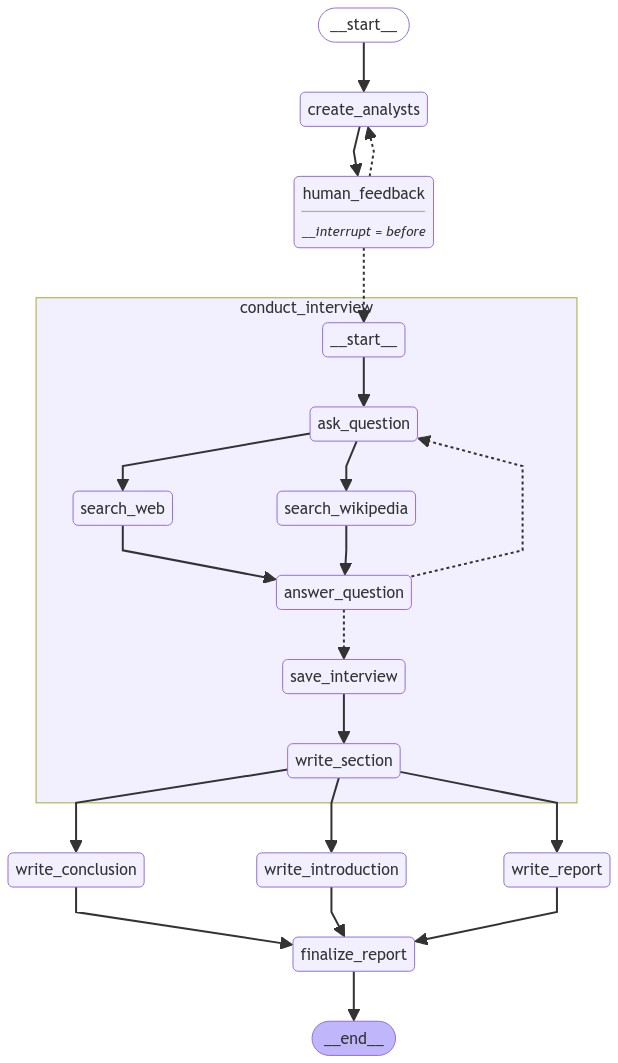

In [24]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [25]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technical Analyst
Description: Dr. Carter focuses on the technical advantages and innovations brought by adopting LangGraph. She is particularly interested in how LangGraph can improve system efficiency, scalability, and integration with existing technologies.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Strategist
Description: Michael Thompson analyzes the business benefits of adopting LangGraph. His focus is on cost reduction, return on investment, and competitive advantage. He evaluates how LangGraph can drive business growth and operational efficiency.
--------------------------------------------------
Name: Samantha Lee
Affiliation: User Experience Research Lab
Role: User Experience Analyst
Description: Samantha Lee examines the user experience improvements that LangGraph can offer. She is concerned with usability, user satisfaction, and t

In [26]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a4b4-a84a-6080-8002-b8c1432e2743'}}

In [27]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technical Analyst
Description: Dr. Carter focuses on the technical advantages and innovations brought by adopting LangGraph. She is particularly interested in how LangGraph can improve system efficiency, scalability, and integration with existing technologies.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Strategist
Description: Michael Thompson analyzes the business benefits of adopting LangGraph. His focus is on cost reduction, return on investment, and competitive advantage. He evaluates how LangGraph can drive business growth and operational efficiency.
--------------------------------------------------
Name: Samantha Lee
Affiliation: User Experience Research Lab
Role: User Experience Analyst
Description: Samantha Lee examines the user experience improvements that LangGraph can offer. She is concerned with usability, user satisfaction, and t

In [28]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a4b5-4229-61e2-8004-d32a00c0326b'}}

In [29]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [30]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Adopting LangGraph as an Agent Framework

## Introduction

In the rapidly evolving landscape of artificial intelligence, businesses are increasingly seeking advanced technologies to streamline operations and enhance efficiency. LangGraph, a robust framework for building stateful, multi-actor applications with large language models (LLMs), stands out as a transformative tool. This report delves into the strategic business efficiencies offered by LangGraph, its role in enhancing generative AI models for scalability and market competitiveness, and its impact on data security and privacy. By exploring these facets, we aim to highlight how LangGraph can be a game-changer for businesses looking to leverage AI for complex task automation and operational excellence.

---



In the rapidly evolving landscape of artificial intelligence, businesses are increasingly adopting advanced technologies to streamline operations, enhance efficiency, and maintain robust data security. LangGraph, a robust framework for building stateful, multi-actor applications with large language models (LLMs), stands out as a transformative tool for these purposes. This report consolidates insights from various analyses to highlight the strategic benefits of adopting LangGraph as an agent framework.

LangGraph excels in handling complex, bespoke tasks essential for modern business operations. Unlike simpler frameworks, LangGraph is adept at creating and managing sophisticated workflows involving multiple AI agents, making it particularly beneficial for businesses looking to automate complex processes and improve operational efficiency.

Key insights from the analysis of LangGraph include:

1. **Stateful Multi-Actor Applications**: LangGraph's ability to build stateful applications allows for the creation of dynamic and adaptive workflows. This is crucial for businesses that require real-time adjustments based on evolving data and task requirements [1][2].

2. **Cycles, Controllability, and Persistence**: These core benefits of LangGraph enable businesses to define cyclical processes, maintain control over AI agent actions, and ensure the persistence of data and states across sessions. This leads to more reliable and consistent performance of AI-driven operations [2][3].

3. **Integration and Scalability**: LangGraph's framework supports the integration of diverse AI agent types within a unified system, facilitating the development of scalable solutions. This is particularly advantageous for businesses aiming to expand their AI capabilities without overhauling existing systems [4][5].

4. **Enhanced Performance Evaluation**: By providing tools to evaluate and optimize AI performance, LangGraph helps businesses ensure that their AI solutions are not only effective but also efficient. This is critical for maintaining competitive advantage in a technology-driven market [1][5].

5. **Custom LLM-Backed Experiences**: LangGraph enables the creation of custom experiences powered by LLMs, which can be tailored to specific business needs. This customization potential allows businesses to develop unique solutions that address their particular challenges and opportunities [1][4].

LangGraph also enhances the capabilities of generative AI models, improving scalability and providing a competitive edge in the market. By facilitating the creation of cyclic graphs for LLM-based AI agents, LangGraph allows for more variable and nuanced agent behaviors compared to traditional linear execution models [1]. This approach bridges the gap between the potential of LLMs and the requirements of real-world software development, making it a valuable tool for startups and established businesses alike.

Key insights from this perspective include:

1. **Framework for Controlled AI Applications**: LangGraph provides a structured framework for creating controlled, production-ready AI applications, which is essential for meeting the stringent requirements of real-world software development [1].

2. **Cyclic Graph Topologies**: By viewing agent workflows as cyclic graph topologies, LangGraph enables more nuanced and variable agent behaviors, enhancing the flexibility and adaptability of AI models [2].

3. **Integration with LangChain**: LangGraph is built on top of LangChain, leveraging its capabilities to create more efficient and stateful multi-actor applications. This integration allows for better coordination and checkpointing of different chains or actors using regular Python functions [4].

4. **Real-World Applications**: LangGraph has been successfully applied in complex data analysis scenarios, demonstrating its practical utility and effectiveness in handling diverse AI agent types within a unified framework [5].

5. **Improving Retrieval-Augmented Generation (RAG)**: LangGraph, in conjunction with LangChain, can significantly improve RAG by creating more efficient and conditional workflows, which are essential for generating accurate and contextually relevant responses [6].

In the context of data security and privacy, LangGraph offers a structured framework for defining, coordinating, and executing multiple LLM agents, which can significantly streamline the development of complex AI applications. One of its key features is the ability to create cyclical graphs, essential for developing stateful, multi-actor applications [1]. This capability can enhance the efficiency and reliability of AI-driven processes, which is critical for maintaining data integrity.

However, LangGraph does not enforce best practices as rigorously as some other tools, such as CrewAI. This lack of enforcement can lead to suboptimal results if developers do not adhere to established security protocols [2]. Despite this, LangGraph's flexibility and higher level of control can be advantageous for developers who are well-versed in data security practices.

The recent release of LangGraph v0.2 introduces new checkpointer libraries, including a SQLite checkpointer for local workflows and an optimized Postgres checkpointer for production environments [3]. These enhancements provide increased customization options, which can be leveraged to improve data security measures. Additionally, the introduction of LangGraph Cloud in open beta offers new opportunities for scalable and secure AI application development.

In summary, LangGraph offers a comprehensive solution for businesses looking to leverage AI for complex task automation, operational efficiency, and data security. Its unique features and strategic advantages make it a valuable tool for businesses aiming to stay ahead in a competitive market.


---

## Conclusion

LangGraph emerges as a transformative framework for businesses aiming to leverage AI for enhanced operational efficiency, scalability, and data security. By enabling the creation of stateful, multi-actor applications, LangGraph addresses the complex needs of modern enterprises. Its unique features, such as cycles, controllability, and persistence, offer significant advantages in automating intricate workflows. The integration and scalability capabilities further ensure that businesses can expand their AI solutions seamlessly. Additionally, LangGraph's tools for performance evaluation and custom LLM-backed experiences provide a competitive edge in the market. Despite some challenges in enforcing best practices, LangGraph's advanced features and recent updates make it a valuable asset for businesses focused on strategic efficiency, generative AI model enhancement, and robust data security.

## Sources
[1] https://www.langchain.com/langgraph  
[2] https://github.com/langchain-ai/langgraph  
[3] https://medium.com/@ga3435/ai-agentic-frameworks-2022fe43e78a  
[4] https://www.datacamp.com/tutorial/langgraph-tutorial  
[5] https://github.com/langchain-ai/langgraph/discussions/1093  
[6] https://medium.com/data-science-in-your-pocket/improving-rag-using-langgraph-and-langchain-bb195bfe4b44  
[7] https://opendatascience.com/langgraph-the-future-of-production-ready-ai-agents/  
[8] https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/  
[9] https://towardsdatascience.com/how-to-implement-a-genai-agent-using-autogen-or-langgraph-929135afd34d  
[10] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/  
[11] https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787  
[12] https://blog.langchain.dev/langgraph-v0-2/

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r